#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка библиотек

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor as lgb
from sklearn.ensemble import RandomForestRegressor
from functools import partial
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

## Подготовка

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.tail() 

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Увидели, что наши данные по времени с марта по август.

In [5]:
data.sort_index(inplace=True)
data_day = data.resample('1D').sum()

In [6]:
data = data.resample('1H').sum() #сделали ресемплирование по одному часу, смотря на суммарное количество заказов

## Анализ

**1) Суточный тренд и суточная сезонность**

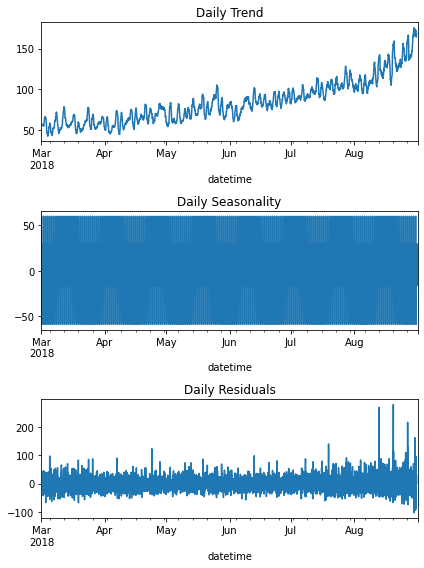

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Daily Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Daily Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Daily Residuals')
plt.tight_layout()
plt.show()

Можем сказать, что есть явный тренд по времени года в использовании такси данного сервиса: ближе к концу лета люди чаще заказывают такси в аэропортах. Оно и логично - летом, осенью люди чаще всего предпочитают улетать на отдых.

---
Остатки необъяснимы.

---
Что касается сезонности, то изучим ее чуть более детально, сделав срез за первые 10 дней июня.

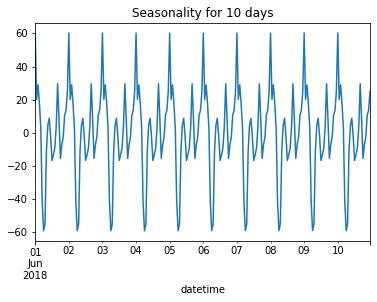

In [8]:
decomposed.seasonal['2018-06-01':'2018-06-10'].plot(ax=plt.gca())
plt.title('Seasonality for 10 days')
plt.show()

Можем предположить, что сезонность использования такси - больше заказов в аэроопортах присутствует ближе к ночи, и спос на такси в аэропорту спадает к утру.

**2) Недельный тренд и недельная сезонность**

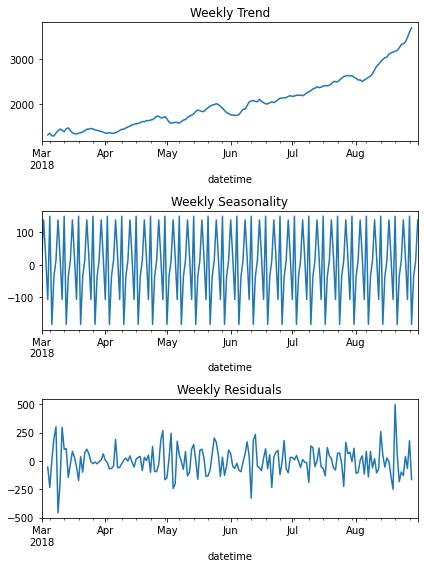

In [9]:
decomposed_day = seasonal_decompose(data_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed_day.trend.plot(ax=plt.gca())
plt.title('Weekly Trend')
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Weekly Seasonality')
plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca())
plt.title('Weekly Residuals')
plt.tight_layout()
plt.show()

Также заметим, что есть и недельный тренд - похожий на тот, что мы смотрели по дням

---
Что насчет недельной сезонности? Посмотрим поближе

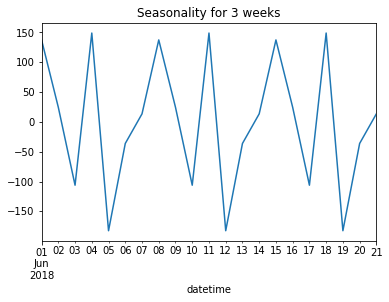

In [10]:
decomposed_day.seasonal['2018-06-01':'2018-06-21'].plot(ax=plt.gca())
plt.title('Seasonality for 3 weeks')
plt.show()

Недельная сезонность есть! А именно:

- Падения спроса на такси в аэропортах случается в начале недели - по понедельникам

- Спрос растет ближе к концу недели, выходным

**3) Скользящее среднее и скользящее стандартное отклонение**

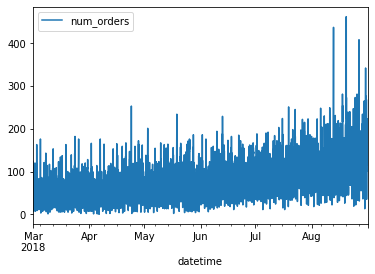

In [11]:
data.plot() #Посмотрим на наши данные
plt.show()

Судя по графику можем сказать, что наше распределение данных не стационарно, так как:

- Стандартное отклонение меняется

- Не так сильно, но и меняется среднее значение

Чтобы данные можно было прогнозировать, попробуем вычислить разности временного ряда, при этом посмотрим на скользящее среднее и скользящее стандартное отклонение.

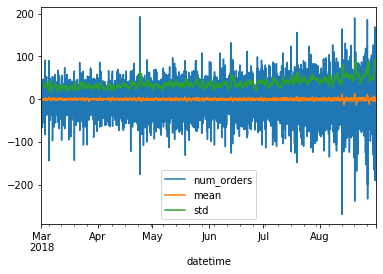

In [12]:
taxi_data = data - data.shift()
taxi_data['mean'] = taxi_data['num_orders'].rolling(24).mean()
taxi_data['std'] = taxi_data['num_orders'].rolling(24).std()
taxi_data.plot()
plt.show()

Перейдем к прогнозированию.

## Обучение

Добавим для обучения новые признаки, такие как: день недели, час. Именно по ним мы выявили сезонность.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 24)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   hour          4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  lag_11        4405 non-null   float64
 14  lag_12        4404 non-null   float64
 15  lag_13        4403 non-null   float64
 16  lag_14        4402 non-null   float64
 17  lag_15        4401 non-null

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

ohe_columns = ['dayofweek', 'hour']
num_columns = ['rolling_mean']

for i in range(1, 25):
    num_columns.append(f'lag_{i}')

In [16]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error')
        )
    ]
)

In [17]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [18]:
param_grid = [
    {
        'models': [RandomForestRegressor(random_state=42)],
        'models__n_estimators': [100],
        'models__max_depth': [5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()] ,
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [19]:
root_mean_squared_error = partial(mean_squared_error, squared=False)
rmse_error = make_scorer(root_mean_squared_error)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    scoring=rmse_error, 
    cv=tscv, 
    n_jobs=-1,
    verbose=2
)

In [20]:
grid_search.fit(X_train, y_train)
    
print(f"Лучшие гиперпараметры: {grid_search.best_params_}")
print (f'Метрика лучшей модели на кросс-валидации: {grid_search.best_score_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   0.8s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   1.1s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   1.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   1.7s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   0.8s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   1.0s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   1.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   1.7s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=passthrough; total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=passthrough; total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=passthrough; total time=   1.0s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=passthrough; total time=   1.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=5, models__n_estimators=100, preprocessor__num=passthrough; total time=   1.6s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=StandardScaler(); total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=MinMaxScaler(); total time=   3.1s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=passthrough; total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=passthrough; total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=passthrough; total time=   1.9s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=passthrough; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=RandomForestRegressor(random_state=42), models__max_depth=10, models__n_estimators=100, preprocessor__num=passthrough; total time=   3.2s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.4s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

[CV] END models=LinearRegression(), preprocessor__num=passthrough; total time=   0.2s
[CV] END models=LinearRegression(), preprocessor__num=passthrough; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV] END models=LinearRegression(), preprocessor__num=passthrough; total time=   0.3s
[CV] END models=LinearRegression(), preprocessor__num=passthrough; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

[CV] END models=LinearRegression(), preprocessor__num=passthrough; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Лучшие гиперпараметры: {'models': RandomForestRegressor(max_depth=5, random_state=42), 'models__max_depth': 5, 'models__n_estimators': 100, 'preprocessor__num': 'passthrough'}
Метрика лучшей модели на кросс-валидации: 27.756048424808107


Лучше всего по метрике RMSE (которая явно получилась менее 48) работает модель RandomForestRegressor(max_depth=5, random_state=42), 'models__max_depth': 5, 'models__n_estimators': 100, 'preprocessor__num': 'passthrough'}.

Метрика RMSE лучшей модели на кросс-валидации: 27.8

## Тестирование

In [21]:
y_pred = grid_search.best_estimator_.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE модели линейной регрессии равна {rmse}')

RMSE модели линейной регрессии равна 47.872663975953635


На тестовых данных модель тоже справилась удачно: метрика RMSE = 47.87 < 48.

Посмотрим на графиках, как выглядит распределение реальных значений и предсказанных.

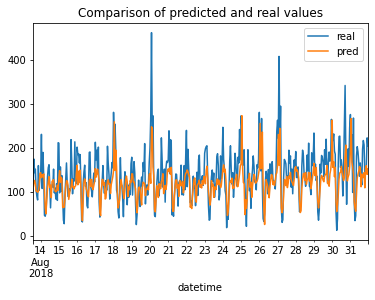

In [25]:
X_test['pred'] = y_pred
X_test['real'] = y_test

fig, ax = plt.subplots()
plt.title('Comparison of predicted and real values')
X_test['real'].plot(ax=ax, legend='real')
X_test['pred'].plot(ax=ax, legend='pred')
plt.show()

In [23]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# оценка качества модели по метрике accuracy
dummy = mean_squared_error(y_test, dummy_model_preds, squared=False)
print('Model rmse =', dummy)

Model rmse = 84.6499381993622


Метрика почти в два раза больше "нормы", значит, работа с моделями была проделана не зря)

## Вывод

В ходе работы мы:

- Загрузили данные и выполнили их ресемплирование по часу

- Выявилить тренд и сезонность

- Привели их стационарному виду

- Обучили разные модели для прогнозирования с разными гипермараметрами : по метрике лучшей оказалась модель линейной регресси
